# Импорты

In [11]:
import numpy as np
import pandas as pd
import pathlib as pl

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
import torchvision.utils
from torch.autograd import Variable
import os
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import time
from torchsummary import summary
import sys
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from google.colab import files
from tqdm.notebook import tqdm
import pathlib
%matplotlib inline

# Проверка среды

Для более быстрой скорости обучения, рекомендуется переключить среду выполнения на GPU

In [12]:
device = torch.cuda.is_available()

In [13]:
torch.cuda.is_available()

True

# Загрузка файлов

In [14]:
files.upload() #сюда необходимо загрузить файл kaggle.

Saving kaggle (8).json to kaggle (8).json


{'kaggle (8).json': b'{"username":"vekosek","key":"a1ce05a8a57393951b804fd29d78271f"}'}

In [15]:
current_directory = pathlib.Path('.')
for curr in current_directory.iterdir():  
    if str(curr)[:6] == 'kaggle':
      os.rename(str(curr), 'kaggle.json')

In [16]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d mohnishsaiprasad/forest-fire-images

forest-fire-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [17]:
!unzip /content/forest-fire-images.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: Data/Train_Data/Fire/F_0.jpg  
  inflating: Data/Train_Data/Fire/F_1.jpg  
  inflating: Data/Train_Data/Fire/F_10.jpg  
  inflating: Data/Train_Data/Fire/F_100.jpg  
  inflating: Data/Train_Data/Fire/F_1000.jpg  
  inflating: Data/Train_Data/Fire/F_1001.jpg  
  inflating: Data/Train_Data/Fire/F_1002.jpg  
  inflating: Data/Train_Data/Fire/F_1003.jpg  
  inflating: Data/Train_Data/Fire/F_1004.jpg  
  inflating: Data/Train_Data/Fire/F_1005.jpg  
  inflating: Data/Train_Data/Fire/F_1006.jpg  
  inflating: Data/Train_Data/Fire/F_1007.jpg  
  inflating: Data/Train_Data/Fire/F_1008.jpg  
  inflating: Data/Train_Data/Fire/F_1009.jpg  
  inflating: Data/Train_Data/Fire/F_101.jpg  
  inflating: Data/Train_Data/Fire/F_1010.jpg  
  inflating: Data/Train_Data/Fire/F_1011.jpg  
  inflating: Data/Train_Data/Fire/F_1012.jpg  
  inflating: Data/Train_Data/Fire/F_1013.jpg  
  inflating: Data/Train_Data/Fire/F_1014.jpg  
  

In [ ]:
!rm /content/forest-fire-images.zip

# Гиперпараметры

In [ ]:
batch_size = 16
learning_rate = 0.01
epochs = 4
num_classes = 2

# Собираем датасет

In [ ]:
img_size = (128, 128)
def images_transform_train():
  new_data = transforms.Compose([
      transforms.Resize(img_size),
      transforms.RandomEqualize(10),
      transforms.RandomRotation(degrees=(-25,20)),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
  ])
  return new_data
def images_transform_test():
  new_data = transforms.Compose([
      transforms.Resize(img_size),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
  ])
  return new_data

In [ ]:
def check_image(path):
  try:
    im = Image.open(path)
    return True
  except:
    return False

In [ ]:
train_set = datasets.ImageFolder('/content/Data/Train_Data',transform=images_transform_train(), is_valid_file=check_image)
test_set = datasets.ImageFolder('/content/Data/Test_Data',transform=images_transform_test(), is_valid_file=check_image)

In [ ]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(test_set, batch_size=batch_size ,shuffle=True, num_workers=2)

# Смотрим файлы

In [ ]:
def show_images(images, labels):
    f, axes= plt.subplots(1, 10, figsize=(30,5))
    for i, axis in enumerate(axes):
        axes[i].imshow(np.squeeze(np.transpose(images[i].numpy(), (1, 2, 0))), cmap='gray')
        axes[i].set_title(labels[i].numpy())
    plt.show()

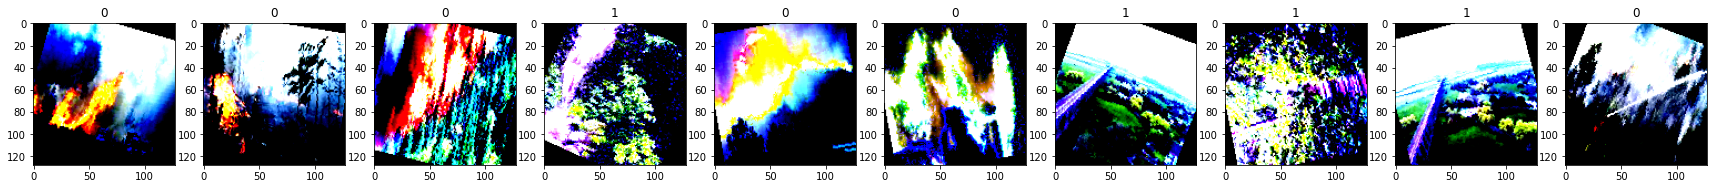

In [ ]:
images, labels = iter(train_loader).next()
show_images(images, labels)

# Загрузка модели

In [ ]:
model = torchvision.models.mobilenet_v2(pretrained=True) # https://habr.com/ru/post/352804/
model.classifier = nn.Sequential(
    nn.Linear(in_features=model.classifier[1].in_features, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=num_classes, bias=True)
  )

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [ ]:
model = model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

In [ ]:
img_size = (3, 128, 128)
summary(model, img_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
             ReLU6-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]             288
       BatchNorm2d-5           [-1, 32, 64, 64]              64
             ReLU6-6           [-1, 32, 64, 64]               0
            Conv2d-7           [-1, 16, 64, 64]             512
       BatchNorm2d-8           [-1, 16, 64, 64]              32
  InvertedResidual-9           [-1, 16, 64, 64]               0
           Conv2d-10           [-1, 96, 64, 64]           1,536
      BatchNorm2d-11           [-1, 96, 64, 64]             192
            ReLU6-12           [-1, 96, 64, 64]               0
           Conv2d-13           [-1, 96, 32, 32]             864
      BatchNorm2d-14           [-1, 96,

# Обучение

In [ ]:
#стохастический градиентый спуск
optimizer = optim.SGD(model.parameters(),lr=learning_rate)
#кросс энтропия
criterion = nn.CrossEntropyLoss()

In [ ]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses = []
    val_losses = []
    train_auc = []
    val_auc = []
    train_auc_epoch = []
    val_auc_epoch = []
    min_loss = np.Inf
    max_acc = 0

    curr_time = time.time()
    y_curr = []
    y_pred=[]
    for epoch in range(epochs):
        y_curr = []
        y_pred = []
        running_loss = 0
        val_loss = 0

        # тренировка модели
        model.train(True)
        en = enumerate(tqdm(train_loader, total=int(len(train_loader))))
        for i, batch in en:
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images) 
            loss = criterion(logits, labels) 
            loss.backward() 
            optimizer.step() 
            optimizer.zero_grad()

            # вычиляем функцию потерь
            running_loss += loss.item()
            
            _, predictes = torch.max(logits,1)
            y_curr += list(labels.data.cpu().numpy().flatten()) 
            y_pred += list(predictes.detach().cpu().numpy().flatten())
        train_auc.append(accuracy_score(y_curr, y_pred))

        # оценка модели
        model.eval()
        for i, batch in enumerate(tqdm(val_loader, total=int(len(val_loader)))):
            bach = images, labels
            images = images.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
            labels = labels.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

            logits = model(images)
            loss = criterion(logits, labels)

            val_loss += loss.item()
            _, predictes=torch.max(logits,1)
            y_curr += list(labels.data.cpu().numpy().flatten()) 
            y_pred += list(predictes.detach().cpu().numpy().flatten())
        
        val_auc.append(accuracy_score(y_curr, y_pred))

        # Средние значения метрик и функции потерь
        running_loss = running_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        train_losses.append(running_loss)
        val_losses.append(val_loss)
        training_auc = train_auc[-1]
        validation_auc = val_auc[-1]
        train_auc_epoch.append(training_auc)
        val_auc_epoch.append(validation_auc)

        # Выбираем лучшую модель
        if max_acc < validation_auc:
            max_acc = validation_auc

        if min_loss >= val_loss:
            min_loss = val_loss

        print('\nEpoch {}\nTrain loss: {:.2f},\nVal loss: {:.2f},\nTrain AUC: {:.2f},\nVal AUC: {:.2f}\n \n ----------------------------------------- \n '.format(epoch+1, running_loss, val_loss, training_auc, validation_auc))

    total_time = time.time() - curr_time
    print('Обучение завершено\nВремя: {:.0f}мин. {:.0f}сек.'.format(total_time // 60, total_time % 60))
    return train_losses,val_losses,train_auc ,val_auc,train_auc_epoch,val_auc_epoch

In [ ]:
train_losses, val_losses, train_auc, val_auc, train_auc_epoch, val_auc_epoch = train(model, train_loader, val_loader, criterion, optimizer, epochs)

  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]


Epoch 1
Train loss: 0.25,
Val loss: 0.00,
Train AUC: 0.90,
Val AUC: 0.90
 
 ----------------------------------------- 
 


  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]


Epoch 2
Train loss: 0.14,
Val loss: 0.00,
Train AUC: 0.95,
Val AUC: 0.95
 
 ----------------------------------------- 
 


  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]


Epoch 3
Train loss: 0.11,
Val loss: 0.00,
Train AUC: 0.96,
Val AUC: 0.96
 
 ----------------------------------------- 
 


  0%|          | 0/289 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]


Epoch 4
Train loss: 0.09,
Val loss: 0.81,
Train AUC: 0.97,
Val AUC: 0.97
 
 ----------------------------------------- 
 
Обучение завершено
Время: 2мин. 43сек.


# Визуализация обучения

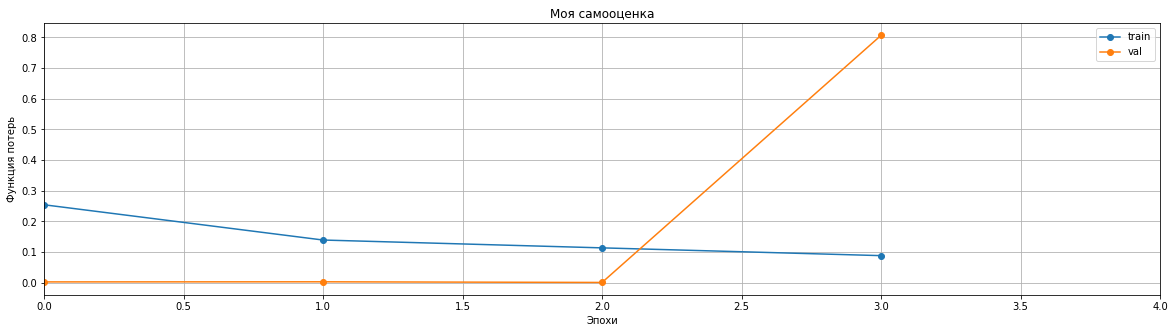

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(train_losses, '-o', label="train")
plt.plot(val_losses, '-o', label="val")
plt.xlabel('Эпохи')
plt.ylabel('Функция потерь')
plt.xlim([0,3])
plt.grid()
plt.title('Моя самооценка')
plt.legend()

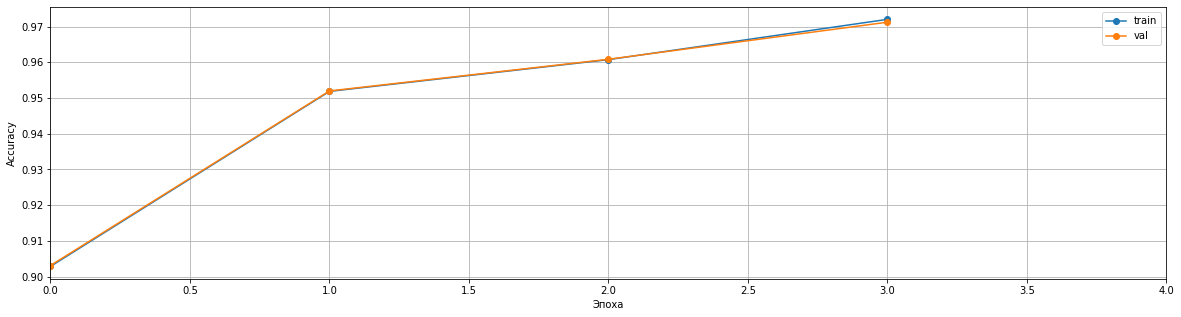

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(train_auc_epoch, '-o', label="train")
plt.plot(val_auc_epoch, '-o', label="val")
plt.xlabel("Эпоха")
plt.ylabel("Accuracy")
plt.xlim([0,3])
plt.grid()
plt.legend()

# Тест

In [ ]:
def test(model, testloader):
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        y_pred = []
        y_actual = []
        for i, batch in enumerate(testloader):
            images, labels = batch
            
            images = images.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
            labels = labels.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
            
            logits = model(images)
            
            show_images(torch.Tensor.cpu(images)[:10], torch.Tensor.cpu(logits)[:10])

            y_actual += list(np.array(labels.detach().to('cpu')).flatten())

            _, predictes = torch.max(logits, 1)
            y_pred += list(np.array(predictes.detach().to('cpu')).flatten())
            
            n_samples += labels.shape[0]

            n_correct += (predictes == labels).sum().item()
            
        y_actual = np.array(y_actual).flatten()
        y_pred = np.array(y_pred).flatten()
        acc = classification_report(y_actual,y_pred,target_names = test_set.classes)
        print(f"{acc}")

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


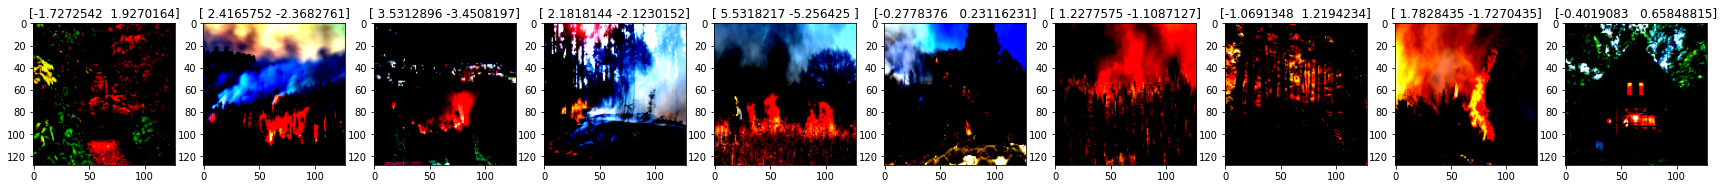

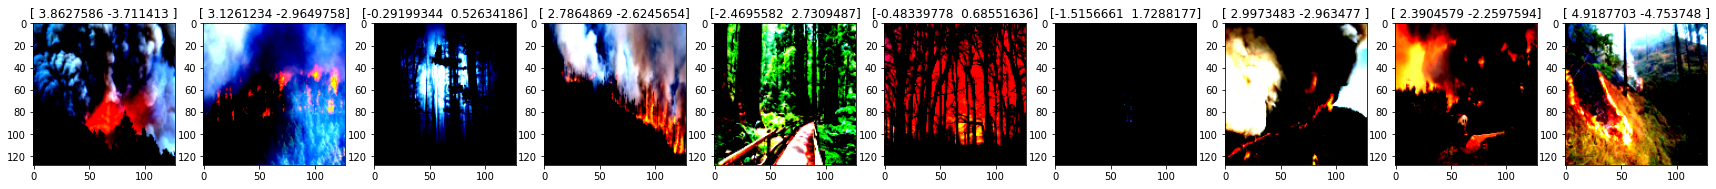

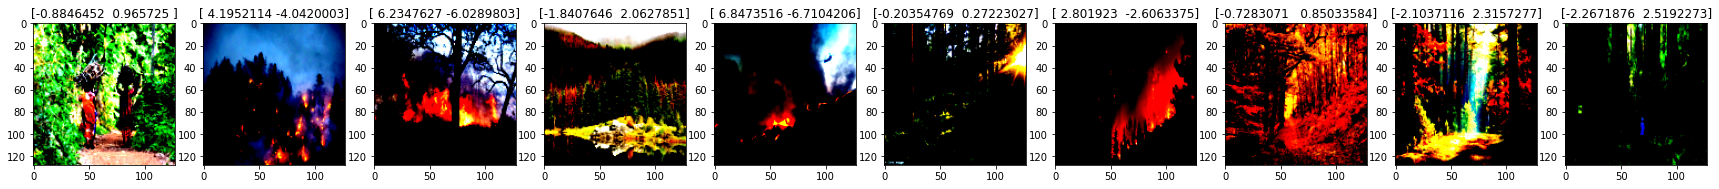

IndexError: ignored

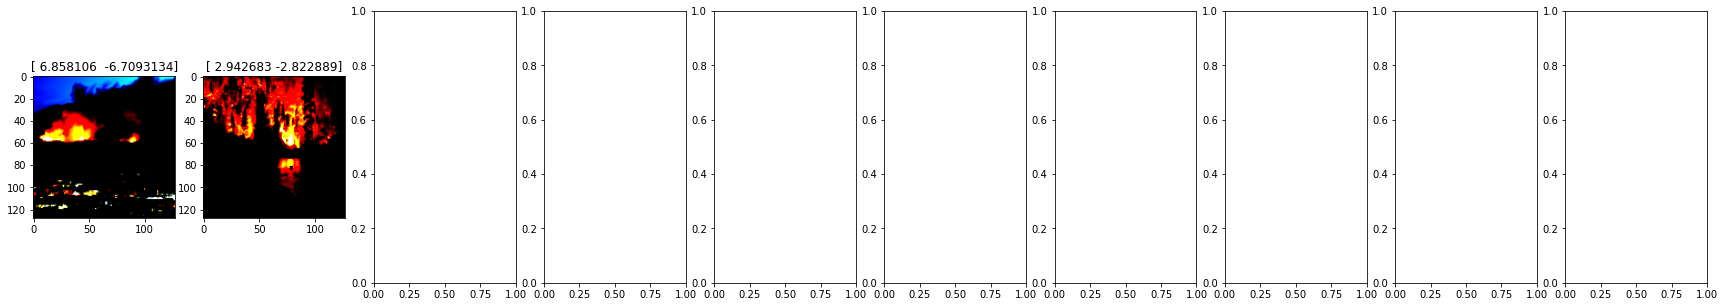

In [ ]:
test(model, val_loader)

# Сохранение модели

In [ ]:
dummy_input = Variable(torch.randn(1, 3, 128, 128))
torch.onnx.export(model.to('cpu'), dummy_input, '/content/saved_model.onnx')